# Fetal ECG Extraction from Single-Channel Maternal ECG Using Singular Value Decomposition

> Partha Pratim Kanjilal,* Member, ZEEE, Sarbani Palit, Member, ZEEE, and Goutam Saha

Experiments are based on public dataset ADFECGDB

## Outline of the Extraction Procedure

### 1. Separation of the mECG component from the composite signal
The data are first arranged in the form of a matrix $A$ such that the consecutive maternal ECG cycles occupy the consecutive rows, and the peak maternal component lies in the same column. SVD is performed on $A$, and $A_M = u_1 \sigma_1 (v_1)^T$ is separated from $A$, forming $A_{R1}=A-A_M$

### 2. Extraction of the fECG component
The time series formed from the successive rows of $A_{R1}$ will contain the fECG component along with noise; this series is rearranged into a matrix $B$ such that each row contains one fetal ECG cycle, with the peak value lying in the same column. SVD is performed on $B$, from which the most dominant component $u_1 \sigma_1 (v_1)^T$ is extracted, which will give the desiderd fECG component.

## Experimental Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyedflib  # to read EDF files

import neurokit2 as nk  # for ECG preprocessing and segmentation

from scipy.linalg import svd  # for Singular Value Decomposition
from scipy.signal import find_peaks  # alternative resampling method if needed

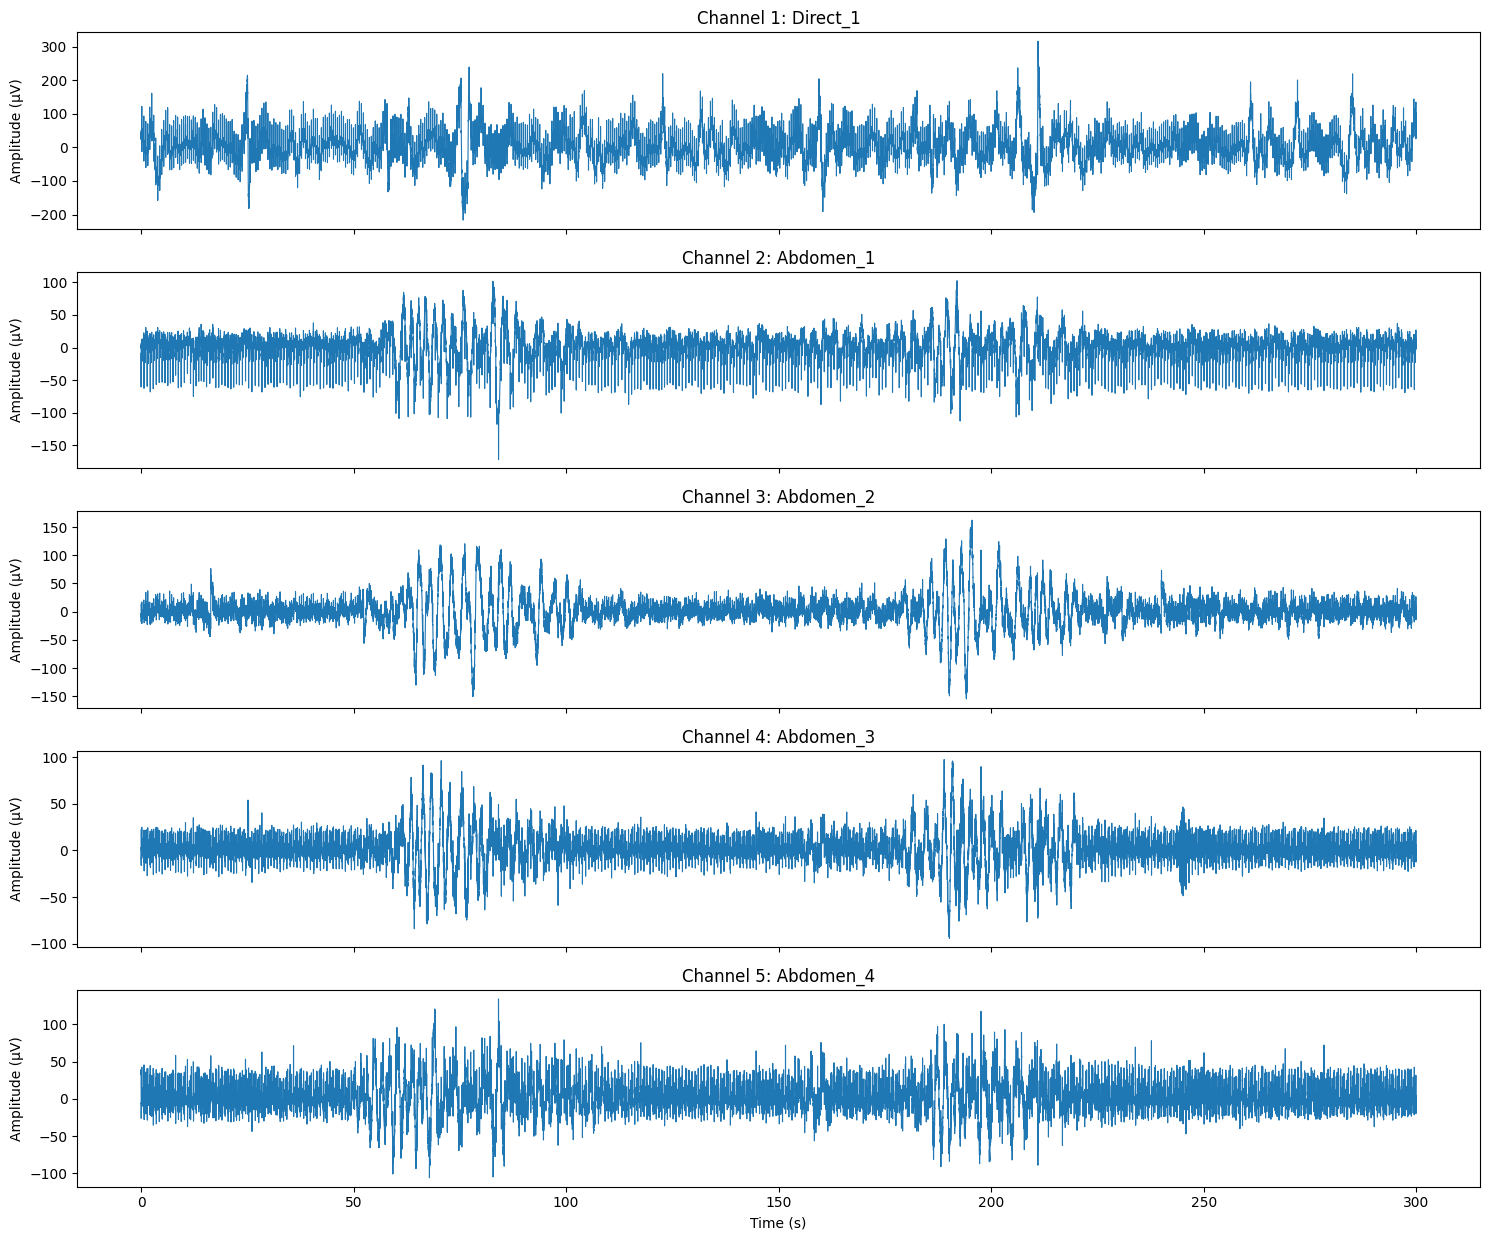

In [2]:
# Load EDF file
edf_path = "../data/raw/r01.edf"
edf = pyedflib.EdfReader(edf_path)

# Get signal info
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
sampling_rate = edf.getSampleFrequency(0)
signal_duration = edf.getFileDuration()
n_samples = edf.getNSamples()[0]
time_vector = np.linspace(0, signal_duration, n_samples)

# Create subplots
fig, axes = plt.subplots(n_channels, 1, figsize=(15, 2.5 * n_channels), sharex=True)

for i in range(n_channels):
    signal = edf.readSignal(i)
    axes[i].plot(time_vector, signal, linewidth=0.8)
    axes[i].set_title(f"Channel {i+1}: {channel_labels[i]}")
    axes[i].set_ylabel("Amplitude (µV)")

axes[-1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()

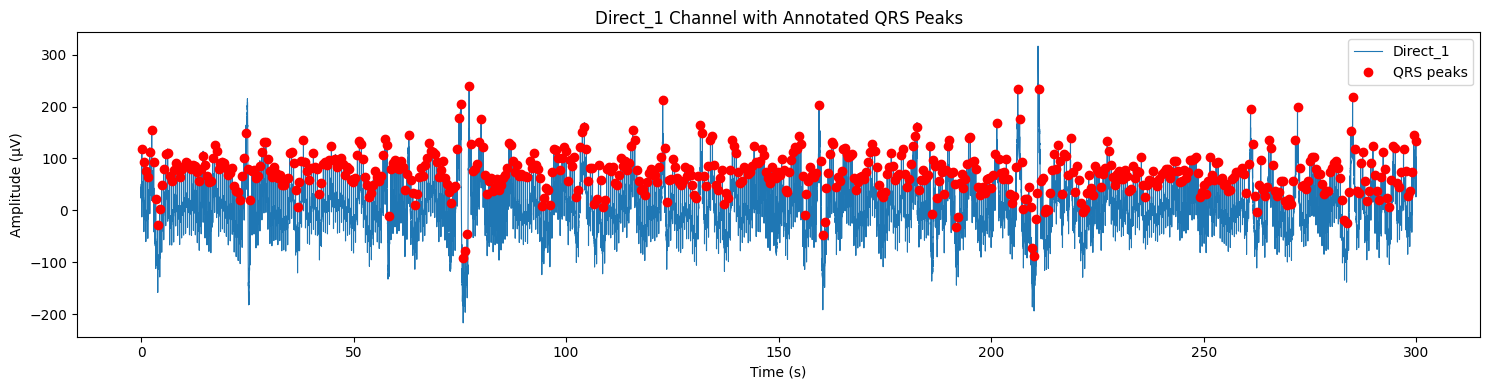

In [3]:
# Read Direct_1 signal only (assumed to be channel 0)
direct_1_signal = edf.readSignal(0)
abdomen_signal = edf.readSignal(1)  # Assuming channel 1 is Abdominal

# Read annotations (assumed to be fetal QRS peaks)
onsets, durations, labels = edf.readAnnotations()
qrs_times = [onsets[i] for i, lbl in enumerate(labels) if lbl.strip().upper() == "QRS"]

# Interpolate signal to get amplitude at annotation times
signal_interp = np.interp(qrs_times, time_vector, direct_1_signal)

# Plot Direct_1 with QRS peaks
plt.figure(figsize=(15, 4))
plt.plot(time_vector, direct_1_signal, label="Direct_1", linewidth=0.8)
plt.plot(qrs_times, signal_interp, 'ro', label="QRS peaks")
plt.title("Direct_1 Channel with Annotated QRS Peaks")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.tight_layout()
plt.show()

In [4]:
def interpolate_segment(y, target_length):
    original_length = len(y)
    x = np.zeros(target_length)

    for j in range(target_length):
        r_j = (j) * (original_length - 1) / (target_length - 1) + 1  # r_j ∈ [1, original_length]
        j_star = int(np.floor(r_j)) - 1  # 0-based index
        delta = r_j - (j_star + 1)

        if j_star + 1 < original_length:
            x[j] = y[j_star] + (y[j_star + 1] - y[j_star]) * delta
        else:
            x[j] = y[j_star]  # Edge case: last value
    return x

def build_matrix_interpolated(signal, estimated_starts, target_length):
    segments = []
    for i in range(len(estimated_starts) - 1):
        start = estimated_starts[i]
        end = estimated_starts[i + 1]
        segment = signal[start:end]
        interpolated = interpolate_segment(segment, target_length)
        segments.append(interpolated)

    return np.array(segments)

def build_matrix(signal, row_length):
    n_rows = len(signal) // row_length
    matrix = np.array([signal[i*row_length:(i+1)*row_length] for i in range(n_rows)])
    return matrix

def svr_spectrum(signal, n_min, n_max):
    sv_ratios = []
    n_values = range(n_min, n_max + 1)
    
    for n in n_values:
        A = build_matrix(signal, n)
        if A.shape[0] < 2 or A.shape[1] < 2:
            sv_ratios.append(0)
            continue
        
        U, S, VT = np.linalg.svd(A, full_matrices=False)
        if len(S) >= 2 and S[1] != 0:
            sv_ratios.append(S[0] / S[1])
        else:
            sv_ratios.append(0)
    
    return list(n_values), sv_ratios

def sliding_window_svd_extraction(A, window_size):
    m, n = A.shape
    if window_size > m:
        raise ValueError("window_size must be less or equal to number of rows in A")

    extracted_mECG = np.zeros(m)  # To store extracted mECG segments
    residual_matrix = A.copy()

    # For each sliding window position
    for i in range(m - window_size + 1):
        window = residual_matrix[i:i+window_size, :]

        # SVD decomposition
        U, S, VT = np.linalg.svd(window, full_matrices=False)
        u1 = U[:, 0].reshape(-1, 1)
        sigma1 = S[0]
        v1 = VT[0, :].reshape(1, -1)

        # Rank-1 approximation
        approx = sigma1 * np.dot(u1, v1)

        # The last row of approx corresponds to the extracted mECG for this window's last row
        extracted_mECG[i + window_size - 1] = approx[-1, :].mean()  # Aggregate over period (e.g., mean)

        # Subtract the last row approx from residual_matrix (for the last row of the window)
        # Here, we update the residual_matrix to remove the estimated maternal ECG
        residual_matrix[i + window_size - 1, :] -= approx[-1, :]

    # Flatten the residual matrix back to a 1D signal (concatenate rows)
    residual_signal = residual_matrix.flatten()

    return extracted_mECG, residual_signal

To convert period length (in samples) to heart rate in beats per minute (bpm), we can use this formula:

$$n = \frac{samples/second \times 60 seconds/minute}{beats/minute}$$

Where:
- $f_s$ is the sampling rate in Hz (e.g. 1000 for 1kHz)
- $n$ is the period length in samples

$$n_{max} = \frac{1000 \times 60}{50} = 1200$$
$$n_{min} = \frac{1000 \times 60}{160} = 375$$

Optimal period length: 377 samples (159.15 bpm)


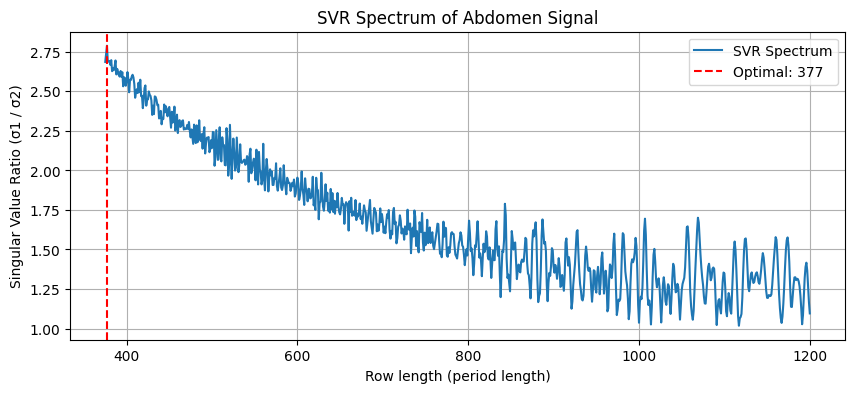

In [5]:
# Parameters
n_min = 375
n_max = 1200

# Compute SVR spectrum
n_vals, svrs = svr_spectrum(abdomen_signal, n_min, n_max)

# Find optimal period (max SVR)
optimal_period = n_vals[np.argmax(svrs)]
optimal_bpm = (sampling_rate * 60) / optimal_period
print(f"Optimal period length: {optimal_period} samples ({optimal_bpm:.2f} bpm)")

# Plot SVR spectrum
plt.figure(figsize=(10, 4))
plt.plot(n_vals, svrs, label='SVR Spectrum')
plt.axvline(optimal_period, color='red', linestyle='--', label=f'Optimal: {optimal_period}')
plt.xlabel("Row length (period length)")
plt.ylabel("Singular Value Ratio (σ1 / σ2)")
plt.title("SVR Spectrum of Abdomen Signal")
plt.grid(True)
plt.legend()
plt.show()

From now on, we will always use <code>direct_1_signal</code> as the fECG ground truth and <code>abdomen_signal</code> as one of the four composite ECGs which contains fECG and mECG together. In order to change the abdomen signal, put a number between 1 and 4 in <code>abdomen_signal = edf.readSignal(1)</code> at the beginning of the previous script.

## Method #1 and #2
The most commonly occurring period length for the mECG is considered to be the row lenght ($n$) of the data matrix $A$. The consecutive periods with respect to mECG cycles are aligned into the consecutive rows of $A$, and linearly interpolated data are used for the periods shorter than n. The row length of matrix $B$ is also decided similarly with respect to the fECG cycles. The part of the data in $u_1 \sigma_1 (v_1)^T$ that corresponds to the interpolated data in $A$ or $B$ is eliminated while forming the extracted mECG and the fECG series.

The most likely periodic length (in terms of energy) of the most dominant periodic component present in the signal is considered to be the row lengths of the data matrices $A$ and $B$. The SVR spectrum of the composite maternal ECG signal is used to determine the period length (say $n$) of the mECG component in the composite signal. The periodic segments which are not equal to $n$ in length, are compressed or expanded to the length $n$ as follows.

The data segment $y(1), y(2), ..., y(n^*)$, can be replaced by the set $x(1), x(2), ..., x(n)$ where $n \ne n^*$, using the transformation

$$x(j) = y(j^*) + (y(j^* + 1) - y(j^*))(r_j - j^*)$$

where $r_j = \frac{(j - 1)(n^* - 1)}{(n - 1) + 1}$, and $j^*$ is the integral part of $r_j$. Thus the successive (pseudo-)periods of the composite ECG series $\{y( \cdot )\}$ are converted into data lengths having the same period length $n$, which are now aligned in the rows of the matrix $A$. Appropriate reverse transformation is performed on the data at the time of reconstruction of the extracted mECG series.

The period length of the fECG component is determined from the SVR spectrum of the residual series. The subsequent steps for arranging data into $B$ are the same as above.

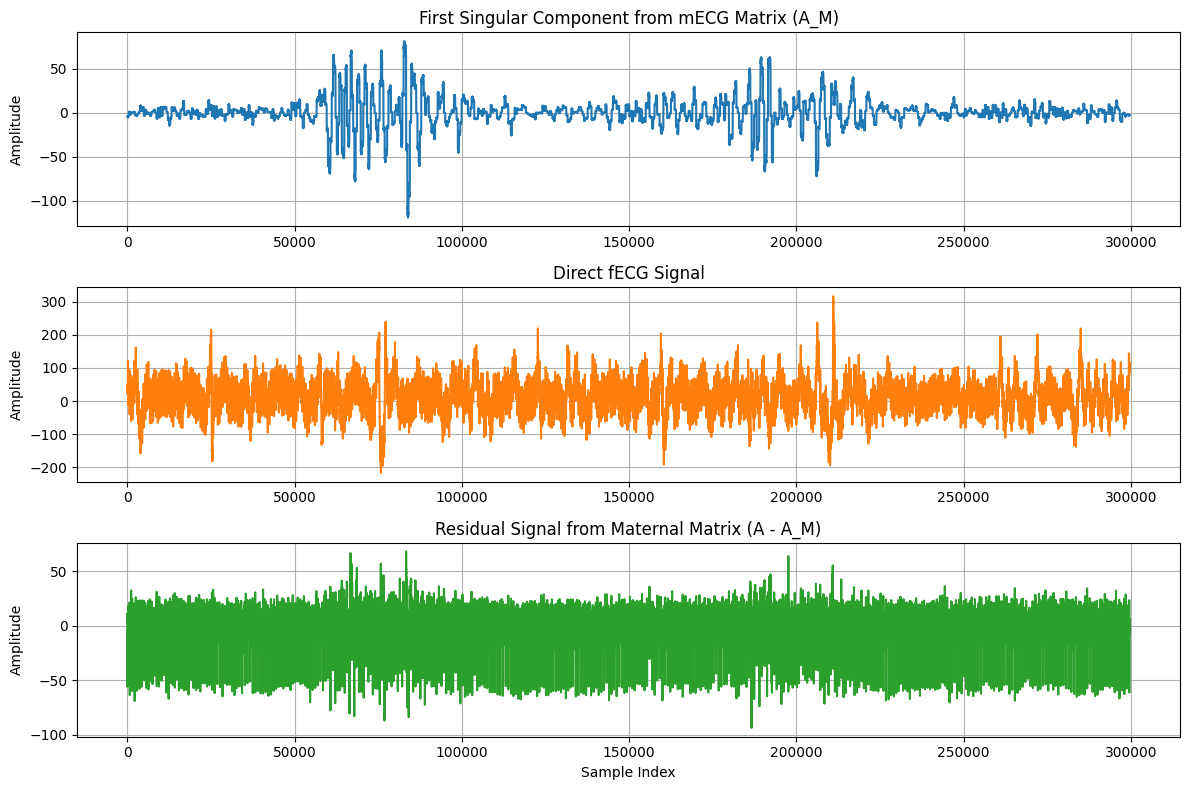

In [6]:
peaks, _ = find_peaks(abdomen_signal, distance=sampling_rate * 0.5)  # assume ~120 BPM

# A = A = build_matrix_interpolated(abdomen_signal, peaks, optimal_period)
A = A = build_matrix(abdomen_signal, optimal_period)
U, S, VT = np.linalg.svd(A, full_matrices=False)

u1_A = U[:, 0].reshape(-1, 1)  # First left singular vector
sigma1_A = S[0]  # First singular value
v1_A = VT[0, :].reshape(-1, 1)  # First right singular vector

A_M = np.dot(u1_A, sigma1_A * v1_A.T)  # Reconstructed matrix using first singular value and vector
A_M_flat = A_M.flatten()
A_residual = A - A_M  # Residual matrix after removing first component
A_residual_flat = A_residual.flatten()

# Optional: Trim Direct_1_signal to match A_M_flat length
min_len = min(len(direct_1_signal), len(A_M_flat))
A_M_flat = A_M_flat[:min_len]
direct_1_trimmed = direct_1_signal[:min_len]
A_residual_flat = A_residual_flat[:min_len]

# Plot
plt.figure(figsize=(12, 8))

# Subplot 1: First Singular Component (fECG extracted)
plt.subplot(3, 1, 1)
plt.plot(A_M_flat, color='tab:blue')
plt.title("First Singular Component from mECG Matrix (A_M)")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 2: Direct fECG Signal (Reference)
plt.subplot(3, 1, 2)
plt.plot(direct_1_trimmed, color='tab:orange')
plt.title("Direct fECG Signal")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 3: Residual of A (A - A_M)
plt.subplot(3, 1, 3)
plt.plot(A_residual_flat, color='tab:green')
plt.title("Residual Signal from Maternal Matrix (A - A_M)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

Optimal period length: 377 samples (159.15 bpm)


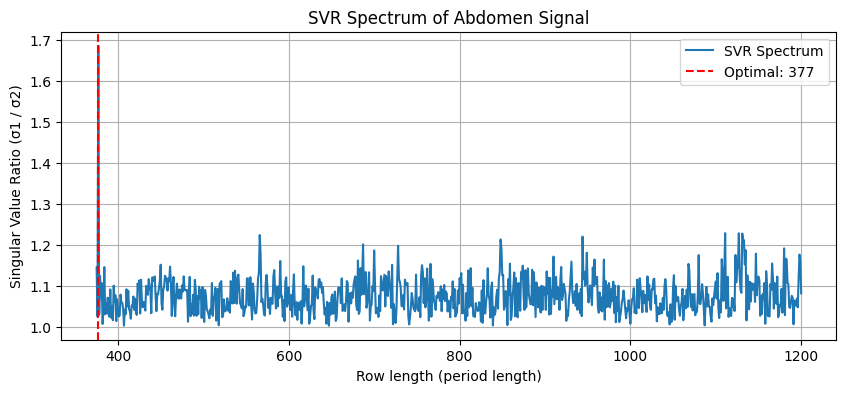

In [7]:
# Parameters
n_min = 375
n_max = 1200

# Compute SVR spectrum
n_vals, svrs = svr_spectrum(A_residual_flat, n_min, n_max)

# Find optimal period (max SVR)
optimal_period = n_vals[np.argmax(svrs)]
optimal_bpm = (sampling_rate * 60) / optimal_period
print(f"Optimal period length: {optimal_period} samples ({optimal_bpm:.2f} bpm)")

# Plot SVR spectrum
plt.figure(figsize=(10, 4))
plt.plot(n_vals, svrs, label='SVR Spectrum')
plt.axvline(optimal_period, color='red', linestyle='--', label=f'Optimal: {optimal_period}')
plt.xlabel("Row length (period length)")
plt.ylabel("Singular Value Ratio (σ1 / σ2)")
plt.title("SVR Spectrum of Abdomen Signal")
plt.grid(True)
plt.legend()
plt.show()

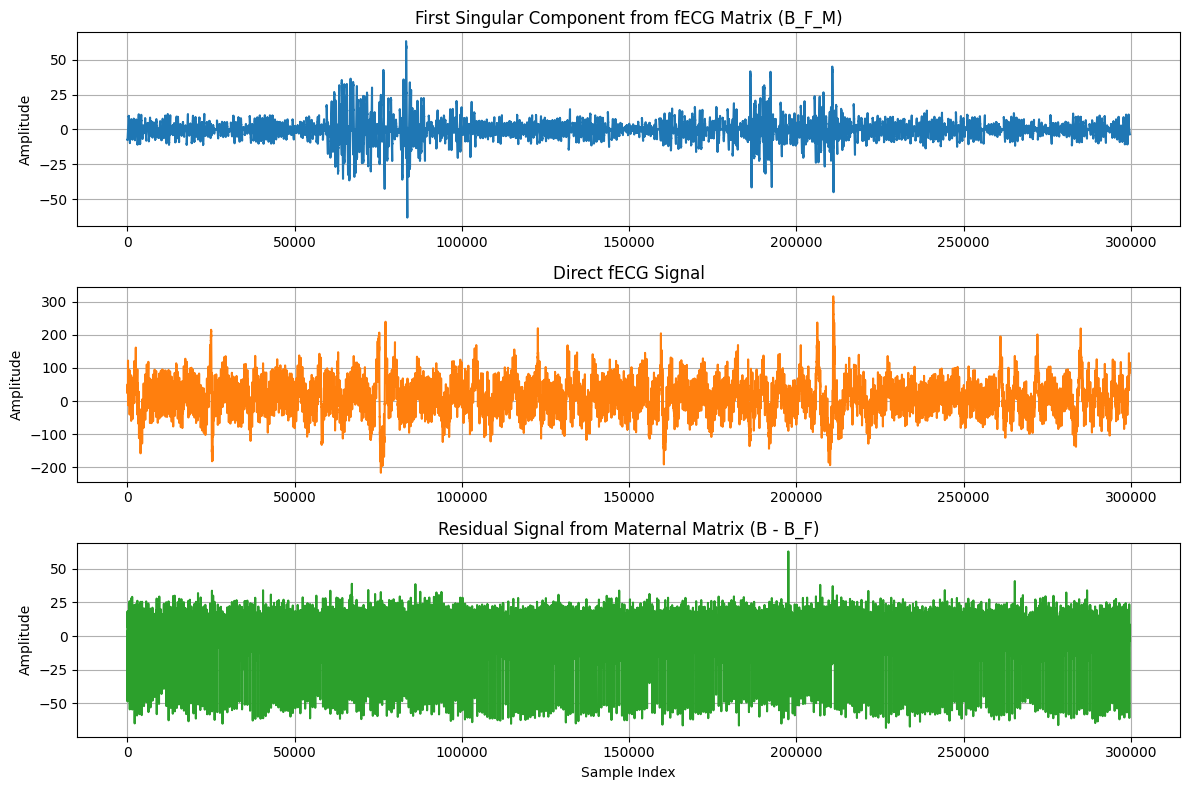

In [8]:
peaks, _ = find_peaks(A_residual_flat, distance=sampling_rate * 0.5)  # assume ~120 BPM

# B = build_matrix_interpolated(A_residual_flat, peaks, optimal_period)
B = build_matrix(A_residual_flat, optimal_period)
U, S, VT = np.linalg.svd(B, full_matrices=False)

u1_B = U[:, 0].reshape(-1, 1)  # First left singular vector
sigma1_B = S[0]  # First singular value
v1_B = VT[0, :].reshape(-1, 1)  # First right singular vector

B_F = np.dot(u1_B, sigma1_B * v1_B.T)  # Reconstructed matrix using first singular value and vector
B_F_flat = B_F.flatten()
B_residual = B - B_F  # Residual matrix after removing first component
B_residual_flat = B_residual.flatten()

# Optional: Trim Direct_1_signal to match B_F_flat length
min_len = min(len(direct_1_signal), len(B_F_flat))
B_F_flat = B_F_flat[:min_len]
direct_1_trimmed = direct_1_signal[:min_len]
B_residual_flat = B_residual_flat[:min_len]

# Plot
plt.figure(figsize=(12, 8))

# Subplot 1: First Singular Component (fECG extracted)
plt.subplot(3, 1, 1)
plt.plot(B_F_flat, color='tab:blue')
plt.title("First Singular Component from fECG Matrix (B_F_M)")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 2: Direct fECG Signal (Reference)
plt.subplot(3, 1, 2)
plt.plot(direct_1_trimmed, color='tab:orange')
plt.title("Direct fECG Signal")
plt.ylabel("Amplitude")
plt.grid(True)

# Subplot 3: Residual of A (B - B_F)
plt.subplot(3, 1, 3)
plt.plot(B_residual_flat, color='tab:green')
plt.title("Residual Signal from Maternal Matrix (B - B_F)")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

plt.tight_layout()
plt.show()

## Method #3
Once the $m \times n$ data matrix $A$ is formed, an $m_1 \times n$ ($m_1 \le m$) matrix $\tilde{A}$ is assumed to move over $A$ such that the first row is dropped and a new row is appended for successive locations of the window. $\tilde{A}$ is SV-decomposed, and the last row of $u_1 \sigma_1 (v_1)^T$ is assumed to be the extracted mECG component corresponding to the last row of $\tilde{A}$, which is subtracted from the original composite ECG series. The residual series id arranged into $B$, from which the fECG component is extracted the same way as the mECG component. This scheme is particularly applicable when sufficient amount of data are available.

In [19]:
extracted_mECG, residual_signal = sliding_window_svd_extraction(A, 20)
extracted_fECG, residual_f_signal = sliding_window_svd_extraction(B, 35)


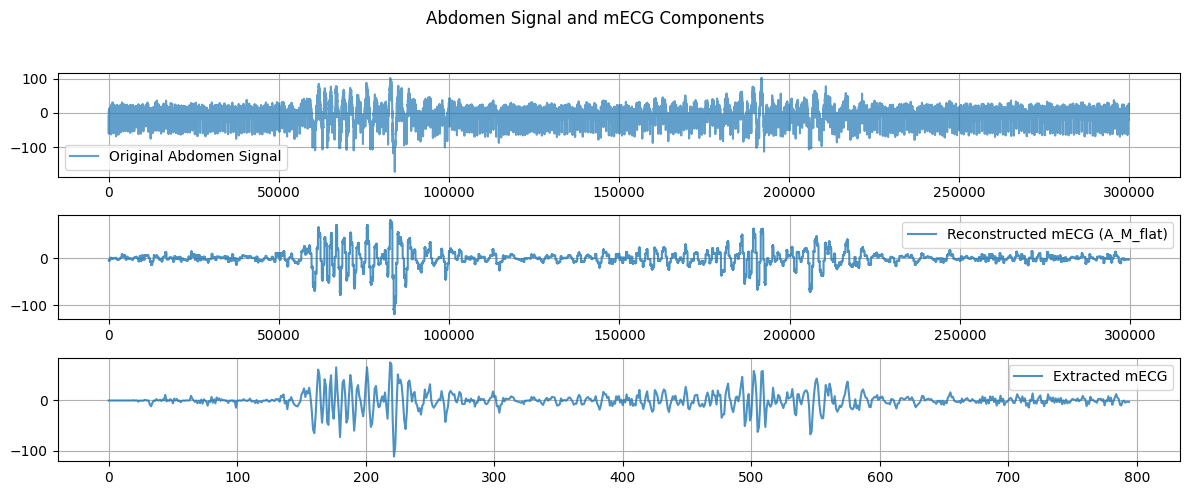

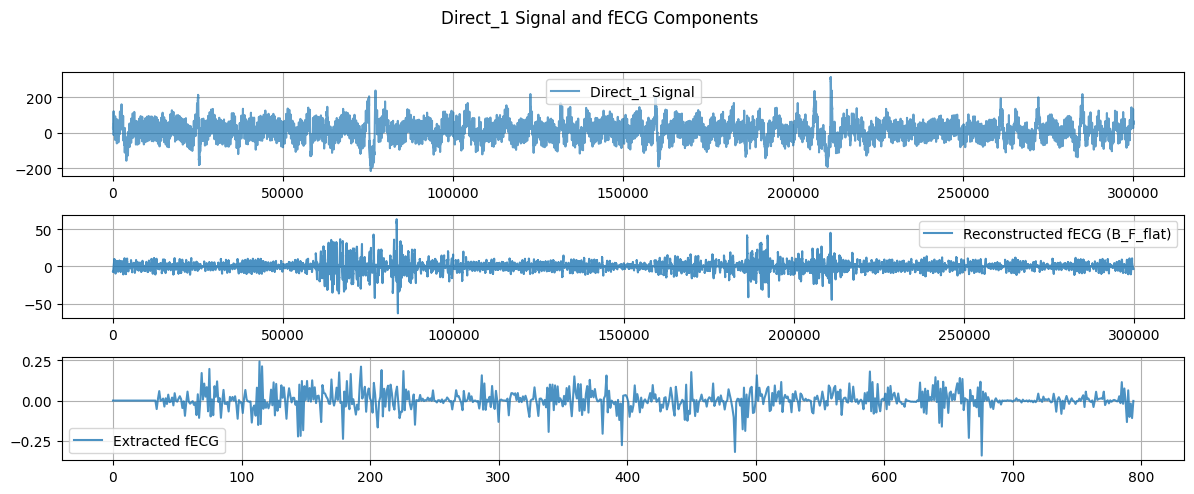

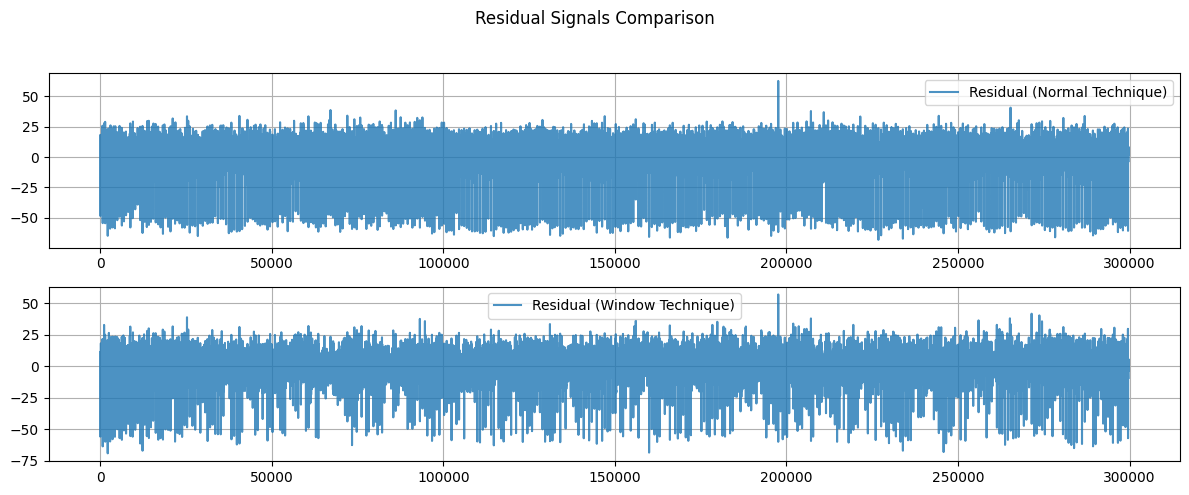

In [20]:
import matplotlib.pyplot as plt

# 1. Plot abdomen_signal with A_M_flat and extracted mECG
plt.figure(figsize=(12, 5))
plt.subplot(3, 1, 1)
plt.plot(abdomen_signal, label='Original Abdomen Signal', alpha=0.7)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(A_M_flat, label='Reconstructed mECG (A_M_flat)', alpha=0.8)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(extracted_mECG, label='Extracted mECG', alpha=0.8)
plt.legend()
plt.grid(True)

plt.suptitle('Abdomen Signal and mECG Components')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 2. Plot direct_1_signal with B_F_flat and extracted fECG
plt.figure(figsize=(12, 5))
plt.subplot(3, 1, 1)
plt.plot(direct_1_signal, label='Direct_1 Signal', alpha=0.7)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(B_F_flat, label='Reconstructed fECG (B_F_flat)', alpha=0.8)
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(extracted_fECG, label='Extracted fECG', alpha=0.8)
plt.legend()
plt.grid(True)

plt.suptitle('Direct_1 Signal and fECG Components')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# 3. Plot residuals from normal and window techniques
plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(B_residual_flat, label='Residual (Normal Technique)', alpha=0.8)
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(residual_f_signal, label='Residual (Window Technique)', alpha=0.8)
plt.legend()
plt.grid(True)

plt.suptitle('Residual Signals Comparison')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
